# 概要
今回は、ライブドアニュースのデータをトピックモデル（LDA）でカテゴライズさせることをやります。

かみ砕いてい言えば、スポーツ系の記事の文章を読み込ませたときに、モデルに「この文章はスポーツカテゴリだ！」と認識させることをやりたい、ということです。

---
LDAは教師なし学習。
一般的に想像される精度で評価することはできない、というのが特徴。

精度では評価しないが、PerplexityとCoherenceという指標を使ってモデルの良さの判断をしている。（精度自体の評価ではなく、モデルがどの程度テキスト情報を圧縮できているのか、人間が解釈しやすいか、を評価するための指標）

参照ページ：https://lunarwoffie.com/lda-topic-model/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


MeCabのインストール、毎度苦労する...

In [ ]:
# 形態素分析ライブラリーMeCab と 辞書(mecab-ipadic-NEologd)のインストール 
!apt-get -q -y install sudo file mecab libmecab-dev mecab-ipadic-utf8 git curl python-mecab > /dev/null
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git > /dev/null 
!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n > /dev/null 2>&1
!pip install mecab-python3 > /dev/null

# シンボリックリンクによるエラー回避
!ln -s /etc/mecabrc /usr/local/etc/mecabrc

!pip install mojimoji

fatal: destination path 'mecab-ipadic-neologd' already exists and is not an empty directory.
ln: failed to create symbolic link '/usr/local/etc/mecabrc': File exists
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
"""
### MeCab辞書をインストール
!sudo apt install mecab
!sudo apt install libmecab-dev
!sudo apt install mecab-ipadic-utf8

### 辞書を使える場所に移す
!mv /etc/mecabrc /usr/local/etc/

### pipでインストール
!pip3 install mecab-python3
!pip install mojimoji
"""

'\n### MeCab辞書をインストール\n!sudo apt install mecab\n!sudo apt install libmecab-dev\n!sudo apt install mecab-ipadic-utf8\n\n### 辞書を使える場所に移す\n!mv /etc/mecabrc /usr/local/etc/\n\n### pipでインストール\n!pip3 install mecab-python3\n!pip install mojimoji\n'

ワードクラウドで日本語を使いたいときは日本語対応フォントを明示的に読み込む必要がある。そのためのコマンド

In [ ]:
# フォント読み込み
!apt-get -y install fonts-ipafont-gothic

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-ipafont-gothic is already the newest version (00303-18ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


In [ ]:
# 各種ライブラリのインポート
import os
import re
import pandas as pd
import pickle
import urllib
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math

# for文の進捗確認に便利なライブラリ
from tqdm import tqdm

# tar.gzファイルの解凍
import tarfile

# 自然言語処理のためのライブラリ
import MeCab
import mojimoji
tagger = MeCab.Tagger("-Ochasen")

# ワードクラウドのためのライブラリ
from wordcloud import WordCloud

# LDA関連のライブラリ
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from gensim import models
from collections import defaultdict

from toolz import frequencies

In [ ]:
DIR         = '/content/drive/MyDrive/colab/lda/'
SOURCE_FILE = 'ldcc-20140209.tar.gz'
TARGET_FILE = 'livedoor/'
FONT_PATH   = '/usr/share/fonts/truetype/fonts-japanese-mincho.ttf'

In [ ]:
FONT_PROPERTY = matplotlib.font_manager.FontProperties(fname = FONT_PATH,
                                                       size  = 24)

In [ ]:
# ディレクトリの変更
os.chdir(DIR)

## ライブドアニュースのデータのDL
データを読み込んだ後は、解凍させる
データのDL自体はコマンドを使った方がラクなので、"wget"コマンドでDLする。

DLしたデータはtar.gz形式で圧縮されているので、それを解凍する必要があるので、"tarfile"ライブラリを使って、解凍している。
解凍時間に結構時間がかかるので、一回解凍したらそれ以降の繰り返しで解凍処理を走らせないように一工夫入れている。

In [ ]:
# データのDL

#! wget "https://www.rondhuit.com/download/ldcc-20140209.tar.gz"

In [ ]:
# 解凍済みフォルダの有無を確認
is_folder_exist = os.path.exists(DIR + TARGET_FILE)

# フォルダが無い時だけ、解凍処理を走らせる
if not is_folder_exist:
  tar = tarfile.open(DIR + SOURCE_FILE, 'r:gz')
  tar.extractall(DIR + TARGET_FILE)

In [ ]:
# フォルダのファイルとディレクトリを確認
files_folders = [name for name in os.listdir("livedoor/text/")]
print(files_folders)

# カテゴリーのフォルダのみを抽出
categories = [name for name in os.listdir(
    "livedoor/text/") if os.path.isdir("livedoor/text/"+name)]
print(categories)

['README.txt', 'CHANGES.txt', 'dokujo-tsushin', 'it-life-hack', 'kaden-channel', 'livedoor-homme', 'movie-enter', 'peachy', 'smax', 'sports-watch', 'topic-news']
['dokujo-tsushin', 'it-life-hack', 'kaden-channel', 'livedoor-homme', 'movie-enter', 'peachy', 'smax', 'sports-watch', 'topic-news']


In [ ]:
# ファイルの中身を確認してみる
file_name = "livedoor/text/movie-enter/movie-enter-6255260.txt"

with open(file_name) as text_file:
    text = text_file.readlines()
    print("0：", text[0])  # URL情報
    print("1：", text[1])  # タイムスタンプ
    print("2：", text[2])  # タイトル
    print("3：", text[3])  # 本文

0： http://news.livedoor.com/article/detail/6255260/

1： 2012-02-07T09:00:00+0900

2： 新しいヴァンパイアが誕生！　ジョニデ主演『ダーク・シャドウ』の公開日が決定

3： 　こんなヴァンパイアは見たことがない！　ジョニー・デップとティム・バートン監督がタッグを組んだ映画『ダーク・シャドウズ（原題）』の邦題が『ダーク・シャドウ』に決定。日本公開日が5月19日に決まった。さらに、ジョニー・デップ演じるヴァンパイアの写真が公開された。



フォルダ名称が「カテゴリ」で、フォルダの中に大量にテキストファイルが存在している。

テキストファイルは、
- 1行目：URL情報
- 2行目：タイムスタンプ（記事が公開された日時？）
- 3行目：タイトル
- 4行目：本文
というデータで入っている。

In [ ]:
# フォルダのファイルとディレクトリを確認
files     = os.listdir("livedoor/text/")
files_dir = [f for f in files if os.path.isdir(os.path.join("livedoor/text/", f))]
files_dir

['dokujo-tsushin',
 'it-life-hack',
 'kaden-channel',
 'livedoor-homme',
 'movie-enter',
 'peachy',
 'smax',
 'sports-watch',
 'topic-news']

## テキストファイルをカテゴリ別に読み込む

この処理も結構時間がかかるので、初めて実行した時に"list_df"というオブジェクトを作成し、2回目以降はそのオブジェクトの有無判定をして、再度処理を繰り返すことを避ける。

In [ ]:
# 結構時間かかるので、ファイルの有無を確認して、
# 無い場合のみデータの読み込み処理をさせる形にする
is_list_exist = os.path.exists("list_df.pkl")

if not is_list_exist:
  list_df = []

  for category in files_dir:
    path = "livedoor/text/" + category + "/"
    
    files      = os.listdir(path)
    files_file = [f for f in files if os.path.isfile(os.path.join(path, f)) and (re.match(category, f))]

    for file_name in files_file:
      file = path + file_name
      
      with open(file) as text_file:
        text = text_file.readlines()
        list_df.append([category, text[2], text[3]])
        #text[0] : # URL情報
        #text[1] : # タイムスタンプ
        #text[2] : # タイトル
        #text[3] : # 本文

  with open('list_df.pkl', mode='wb') as f:
      pickle.dump(list_df, f)
else:
  with open('list_df.pkl', mode='rb') as f:
    list_df = pickle.load(f)

In [ ]:
df = pd.DataFrame(list_df, columns = ["category", "title", "content"])
df.head()

,category,title,content
0,dokujo-tsushin,友人代表のスピーチ、独女はどうこなしている？\n,もうすぐジューン・ブライドと呼ばれる６月。独女の中には自分の式はまだなのに呼ばれてばかり…...
1,dokujo-tsushin,ネットで断ち切れない元カレとの縁\n,携帯電話が普及する以前、恋人への連絡ツールは一般電話が普通だった。恋人と別れたら、手帳に書...
2,dokujo-tsushin,相次ぐ芸能人の“すっぴん”披露 その時、独女の心境は？\n,「男性はやっぱり、女性の“すっぴん”が大好きなんですかね」と不満そうに話すのは、出版関係で...
3,dokujo-tsushin,ムダな抵抗！？ 加齢の現実\n,ヒップの加齢による変化は「たわむ→下がる→内に流れる」、バストは「そげる→たわむ→外に流れ...
4,dokujo-tsushin,税金を払うのは私たちなんですけど！\n,6月から支給される子ども手当だが、当初は子ども一人当たり月額2万6000円が支給されるはず...


In [ ]:
df.groupby("category").count()["title"]

category
dokujo-tsushin    870
it-life-hack      870
kaden-channel     864
livedoor-homme    511
movie-enter       870
peachy            842
smax              870
sports-watch      900
topic-news        770
Name: title, dtype: int64

livedoor-homme以外は、大体700後半～900くらいの記事があることを確認。


# 前処理

今回実施する前処理は、

- 形態素解析→名詞、動詞、形容詞のみを残す
- ストップワードを除去する
- 大文字小文字を統一する
- 半角全角を統一する

In [ ]:
def load_jp_stopwords(path="jp_stop_words.txt"):
    url = 'http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt'
    
    if os.path.exists(path):
        print('File already exists.')
        print("="*30)
    else:
        print('Downloading...')
        print("="*30)
        urllib.request.urlretrieve(url, path)
    
    dff    = pd.read_csv(path, header=None)
    result = dff[0].tolist()
    
    return result

In [ ]:
%time # セルの実行時間を計測するための作法

def preprocess_jp(series):
    stop_words = load_jp_stopwords()
    
    def tokenizer_func(text):
        tokens = []
        node = tagger.parseToNode(str(text))
        
        
        while node:
            features = node.feature.split(',')
            length   = len(features)
                        
            if length > 6:
              surface  = features[6] # 基本形
            else:
              surface = node.surface # featuresで基本形が無い場合は元の単語を使う
            
            is_pass = (surface == '*') or (len(surface) < 2) or (surface in stop_words)

            noun_flag        = (features[0] == '名詞')
            proper_noun_flag = (features[0] == '名詞') & (features[1] == '固有名詞')
            verb_flag        = (features[0] == '動詞') & (features[1] == '自立')
            adjective_flag   = (features[0] == '形容詞') & (features[1] == '自立')

            if is_pass:
              node = node.next
              continue
            elif proper_noun_flag:
              tokens.append(surface)
            elif noun_flag:
              tokens.append(surface)
            elif adjective_flag:
              tokens.append(surface)
            #elif verb_flag:
            #  tokens.append(surface)
            
            node = node.next
        
        return " ".join(tokens)

    series = series.map(tokenizer_func)
    
    # 大文字を小文字化
    series = series.map(lambda x: x.lower())
    # 半角全角変換
    series = series.map(mojimoji.zen_to_han)

    return series

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


In [ ]:
processed_news_ss = preprocess_jp(df.content)
processed_news_ss

File already exists.


0              ｼﾞｭｰﾝ ﾌﾞﾗｲﾄﾞ 6月 お祝い 貧乏 状態 多い 出席 回数 お願い 少ない
1       携帯 電話 普及 恋人 連絡 ﾂｰﾙ 一般 電話 普通 恋人 手帳 相手 連絡 現在 携帯 ...
2       男性 女性 すっぴん 大好き 不満 出版 仮名 最近 すっぴん 写真 掲載 芸能人 多い ﾆ...
3       ﾋｯﾌﾟ 変化 ﾊﾞｽﾄ ﾊﾞｽﾄ 変化 部位 変化 ｳｴｽﾄ お腹 変化 大きい お腹 ﾊ...
4       支給 子ども 手当 当初 子ども 当たり 月額 支給 初年度 半額 支給 年度 子ども 当た...
                              ...                        
7362                 放送 爆笑 問題 ｶｰ ﾎﾞｰｲ ﾗｼﾞｵ 爆笑 問題 田中 裕二 言及
7363                   俳優 黒田 勇樹 中村 瑠衣 暴力 ﾒﾃﾞｨｱ ﾈｯﾄ 掲示板 反響
7364             韓国 専門 ﾆｭｰｽ ｻｲﾄ 公開 搭載 ﾃﾞｼﾞﾀﾙ ｶﾒﾗ ﾚﾋﾞｭｰ 掲載
7365                           ｳｫｰﾙ･ｽﾄﾘｰﾄ･ｼﾞｬｰﾅﾙ 竹島 争奪 紹介
7366    人気 漫画 集英社 週刊 少年ｼﾞｬﾝﾌﾟ 今年 連載 ｽﾀｰﾄ ﾊﾟｼﾞｬﾏ 濱田 発売 ...
Name: content, Length: 7367, dtype: object

In [ ]:
df["wakatigaki"] = processed_news_ss
df.head(10)

,category,title,content,wakatigaki
0,dokujo-tsushin,友人代表のスピーチ、独女はどうこなしている？\n,もうすぐジューン・ブライドと呼ばれる６月。独女の中には自分の式はまだなのに呼ばれてばかり…...,ｼﾞｭｰﾝ ﾌﾞﾗｲﾄﾞ 6月 お祝い 貧乏 状態 多い 出席 回数 お願い 少ない
1,dokujo-tsushin,ネットで断ち切れない元カレとの縁\n,携帯電話が普及する以前、恋人への連絡ツールは一般電話が普通だった。恋人と別れたら、手帳に書...,携帯 電話 普及 恋人 連絡 ﾂｰﾙ 一般 電話 普通 恋人 手帳 相手 連絡 現在 携帯 ...
2,dokujo-tsushin,相次ぐ芸能人の“すっぴん”披露 その時、独女の心境は？\n,「男性はやっぱり、女性の“すっぴん”が大好きなんですかね」と不満そうに話すのは、出版関係で...,男性 女性 すっぴん 大好き 不満 出版 仮名 最近 すっぴん 写真 掲載 芸能人 多い ﾆ...
3,dokujo-tsushin,ムダな抵抗！？ 加齢の現実\n,ヒップの加齢による変化は「たわむ→下がる→内に流れる」、バストは「そげる→たわむ→外に流れ...,ﾋｯﾌﾟ 変化 ﾊﾞｽﾄ ﾊﾞｽﾄ 変化 部位 変化 ｳｴｽﾄ お腹 変化 大きい お腹 ﾊ...
4,dokujo-tsushin,税金を払うのは私たちなんですけど！\n,6月から支給される子ども手当だが、当初は子ども一人当たり月額2万6000円が支給されるはず...,支給 子ども 手当 当初 子ども 当たり 月額 支給 初年度 半額 支給 年度 子ども 当た...
5,dokujo-tsushin,読んでみる？描いてみる？大人の女性を癒す絵本の魅力\n,書店で偶然『うさぎのくれたバレエシューズ』(小峰書店 安房直子/著、南塚直子/イラスト)と...,書店 偶然 うさぎ ﾊﾞﾚｴ ｼｭｰｽﾞ 小峰 書店 安房 直子 南塚 直子 ｲﾗｽﾄ 絵本...
6,dokujo-tsushin,大人になっても解決しない「お昼休み」という問題\n,昨年の秋、希望の職種に転職したカナコさん（30歳／ 商社勤務）。やりがいのある仕事を得て充...,昨年 希望 職種 転職 商社 勤務 やりがい 仕事 充実 思いがけない 問題
7,dokujo-tsushin,結婚しても働くのはなぜ？ 既婚女性のつぶやき\n,「彼の収入が少ないから私も働かなければならないし、それを思うと結婚はもう少し先でもいいかな...,収入 少ない 結婚 いい 結婚 躊躇 収入 仕事 専業 主婦 志望 年収
8,dokujo-tsushin,お肌に優しいから安心 紫外線が気になる独女の夏の対策とは？\n,これからの季節、お肌の天敵と言えば“紫外線”。マーケティング会社トレンダーズ株式会社が、2...,季節 天敵 紫外線 ﾏｰｹﾃｨﾝｸﾞ 会社 株式会社 女性 ｹｱ 意識 調査 実施 外出 ｹ...
9,dokujo-tsushin,初回デートで婚カツ女子がゲンメツする行為って？\n,合コンやパーティー、そして料理教室から農業まで。さまざまなスタイルで男女の人気を集める婚カ...,合ｺﾝ ﾊﾟｰﾃｨｰ 料理 教室 農業 ｽﾀｲﾙ 男女 人気 ｶﾂ 初対面 男女 約束 好意...


## ワードクラウドを描いてみる
各カテゴリのテキストがどんな感じか直感的に把握するためにワードクラウドを描いてみる。


In [ ]:
def show_wordcloud(series):
    long_string = ','.join(list(series.values))
    
    # Create a WordCloud object
    wordcloud = WordCloud(font_path        = FONT_PATH,
                          background_color = "white",
                          max_words        = 1000,
                          contour_width    = 3,
                          contour_color    = 'steelblue')
    
    # Generate a word cloud
    wordcloud.generate(long_string)
    
    # Visualize the word cloud
    plt.imshow(wordcloud)
    plt.show()


dokujo-tsushin


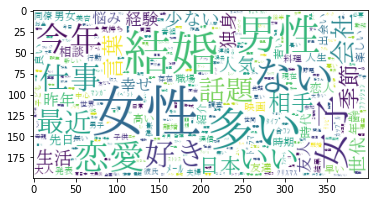


it-life-hack


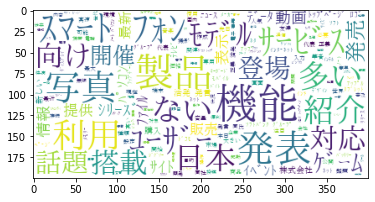


kaden-channel


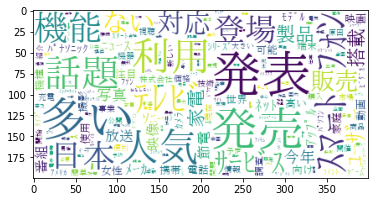


livedoor-homme


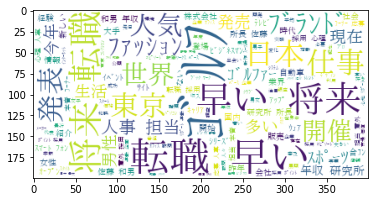


movie-enter


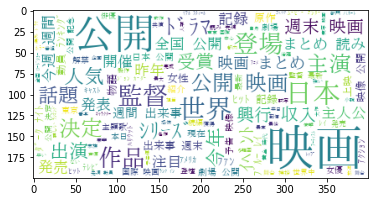


peachy


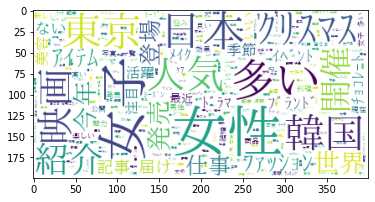


smax


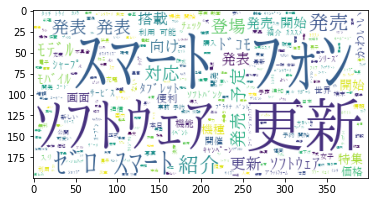


sports-watch


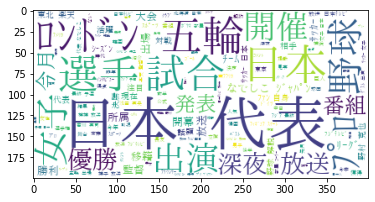


topic-news


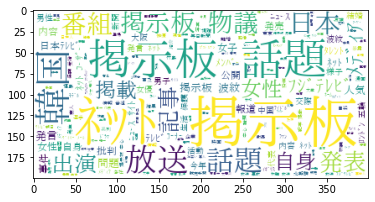

In [ ]:
for category in files_dir:
  df_temp = df[df.category == category]
  print()
  print("==" * 30)
  print(category)
  show_wordcloud(df_temp.wakatigaki)

## 学習データとテストデータに分ける

学習データ9割、テストデータ1割くらいにする。

データを分割するまえに、いったんdfの行をシャッフルしておく。

In [ ]:
df_shuffled=df.sample(frac = 1, random_state = 0).reset_index(drop = True)

N_data    = df.shape[0]
train_ind = int(N_data * 0.9)

df_train = df_shuffled.iloc[:train_ind,:].reset_index(drop = True)
df_test  = df_shuffled.iloc[train_ind:,:].reset_index(drop = True)

# LDAの下準備

In [ ]:
# gensim用に成形
documents = df_train.wakatigaki.values

texts = list(map(lambda x:x.split(), documents))

なんとなく、言われればそのカテゴリだなとわかる。

In [ ]:
# 単語->id変換の辞書作成
dictionary   = Dictionary(texts)

# 使われている文書の数がno_belowより少ない単語を無視し、no_aboveの割合以上の文書に出てくる単語を無視しています。
dictionary.filter_extremes(no_below=3, no_above=0.8)

# Bag-of-Wrodsのコーパスを作成
corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
# 関数new_idfを追加
# このページにあるように、単語が1つしかない場合にtfidfで単語が消えてしまう問題を回避するために
# 関数を追加する
# https://qiita.com/tatsuya-miyamoto/items/f1539d86ad4980624111
def new_idf(docfreq, totaldocs, log_base=2.0, add=1.0):
    return add + math.log(1.0 * totaldocs / docfreq, log_base)

In [ ]:
# tfidf modelの生成
tfidf_model = models.TfidfModel(corpus,
                                wglobal   = new_idf,
                                normalize = False)

In [ ]:
# 作成したモデルにコーパスを適用する
tfidf_corpus = tfidf_model[corpus]

# LDAモデル構築

最適なトピック数を探索する

In [ ]:
%time # セルの実行時間を計測するための作法

coherence_vals  = []
perplexity_vals = []

START = 2
END   = 21
STEP  = 1

for n_topic in tqdm(range(START, END, STEP)):
  # LDAモデルのインスタンス化
  lda = LdaModel(corpus       = tfidf_corpus,
                 num_topics   = n_topic,
                 id2word      = dictionary,
                 random_state = 0)

  # gensimでは、coherenceの計算手法が4つある
  # c_v：もっとも精度が高いけど、計算時間すごいかかる。コーパスはLDA学習と違うコーパスを用意する必要がある
  # u_mass：高速かつ、LDA学習で使ったコーパスを使っても問題ない
  # c_npmiとc_uci：c_vとu_massの中間の性質。でもコーパスはLDA学習と違うコーパスを用意する必要がある
  # 今回は、手軽にやりたいので、u_massを使う
  coherence_model_lda = models.CoherenceModel(model      = lda,
                                              corpus     = tfidf_corpus,
                                              dictionary = dictionary,
                                              coherence  = 'u_mass')
  
  coherence_vals.append(coherence_model_lda.get_coherence())
  perplexity_vals.append(np.exp(-lda.log_perplexity(tfidf_corpus))) # https://analytics-note.xyz/machine-learning/gensim-lda-perplexity/

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.11 µs


100%|██████████| 19/19 [02:51<00:00,  9.01s/it]


## perplexityとcoherenceを可視化
指標
- Perplexity：予測性能
- Coherence：トピックの品質

指標の見方
- Perplexityは低ければ低いほど良い
- Coherenceは高ければ高いほど良い

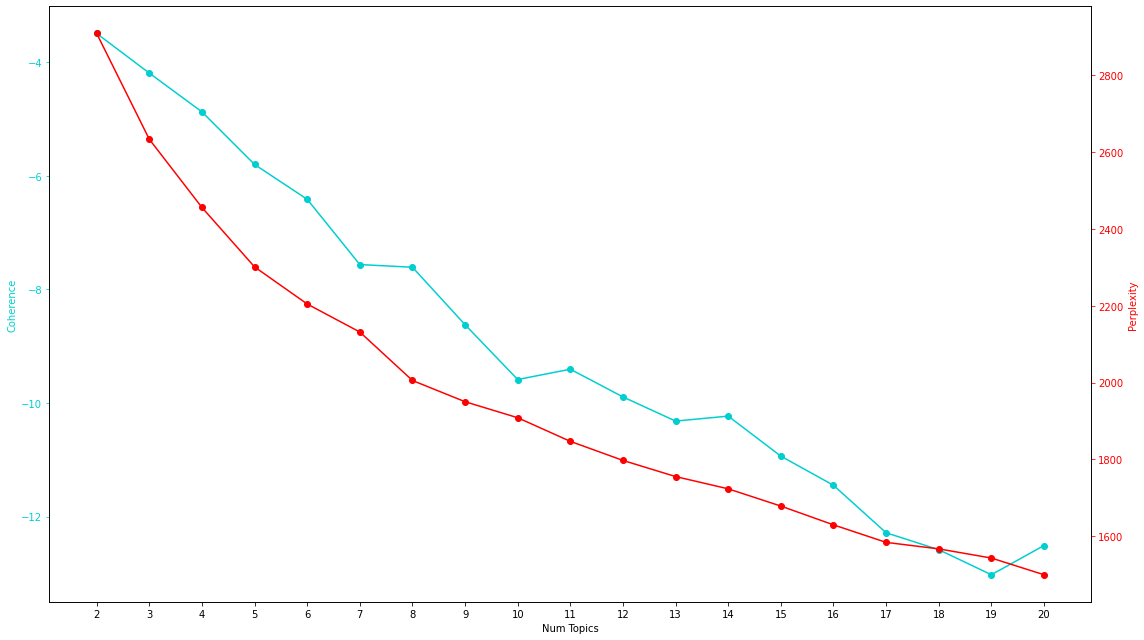

In [ ]:
x = range(START, END, STEP)

fig, ax1 = plt.subplots(figsize=(16,9))

# coherence
c1 = 'darkturquoise'
ax1.plot(x, coherence_vals, 'o-', color = c1)
ax1.set_xlabel('Num Topics')
ax1.set_ylabel('Coherence', color = c1); ax1.tick_params('y', colors = c1)

# perplexity
c2  = 'red'
ax2 = ax1.twinx()
ax2.plot(x, perplexity_vals, 'o-', color = c2)
ax2.set_ylabel('Perplexity', color = c2); ax2.tick_params('y', colors = c2)

# visualise
ax1.set_xticks(x)
fig.tight_layout()
plt.show()

perplexityがビミョーだが、coherenceを考えると、トピック数としては"8"が最適っぽい（と判断することにする）。


In [ ]:
NUM_TOPICS = 8

# LDAモデルのインスタンス化
lda = LdaModel(corpus        = tfidf_corpus,
                num_topics   = NUM_TOPICS,
                id2word      = dictionary,
                random_state = 0)

## トピック内の最頻単語を取得する

トップ10の単語を表示する

In [ ]:
TOP_N_WORDS = 10

# 文書毎の該当トピック
doc_topics = [lda[c] for c in tfidf_corpus]

# トピックの該当数
topic_freq = frequencies([t[0] for dt in doc_topics for t in dt])

for i in range(NUM_TOPICS):
  word_id_list   = [t[0] for t in lda.get_topic_terms(i, topn = TOP_N_WORDS)]
  word_prob_list = [t[1] for t in lda.get_topic_terms(i, topn = TOP_N_WORDS)]

  list_word = [dictionary[id] for id in word_id_list]

  print()
  print("=="*30)
  print('topic_{}'.format(i+1))
  print(list_word)



topic_1
['ｽﾏｰﾄ', 'ﾌｫﾝ', '電話', '携帯', 'ｾﾞﾛ', '多い', '友達', '利用', '写真', '女性']

topic_2
['ﾛｺﾞ', 'ﾌﾟﾛ', '結婚', '年収', '日本', '選手', 'ﾏﾝ', 'ない', 'ﾄｯﾌﾟﾍﾟｰｼﾞ', '女子']

topic_3
['発売', '公開', '映画', '撮影', '世界', 'ｼﾘｰｽﾞ', 'ﾍﾟｯﾄ', '搭載', '動画', '端末']

topic_4
['掲示板', 'ﾈｯﾄ', '話題', '公開', '番組', '映画', '発売', '韓国', '将来', 'ﾆｭｰｽ']

topic_5
['映画', '公開', '紹介', 'ｷｰﾎﾞｰﾄﾞ', '日本', 'ﾄﾞﾗﾏ', 'ｲﾍﾞﾝﾄ', '受賞', '劇場', '世界']

topic_6
['韓国', '更新', '女子', '女性', '記事', '掲載', 'ｿﾌﾄｳｪｱ', 'ﾒｲｸ', '多い', '自動車']

topic_7
['ｻｰﾋﾞｽ', '発表', '販売', '発言', '開始', 'ｸﾞﾙｰﾌﾟ', '提供', '写真', '機能', '搭載']

topic_8
['日本', '代表', '放送', '女子', 'ｻｯｶｰ', '番組', '予選', 'ﾗﾝｷﾝｸﾞ', '開催', '映画']


## ワードクラウドでLDA結果を可視化してみる

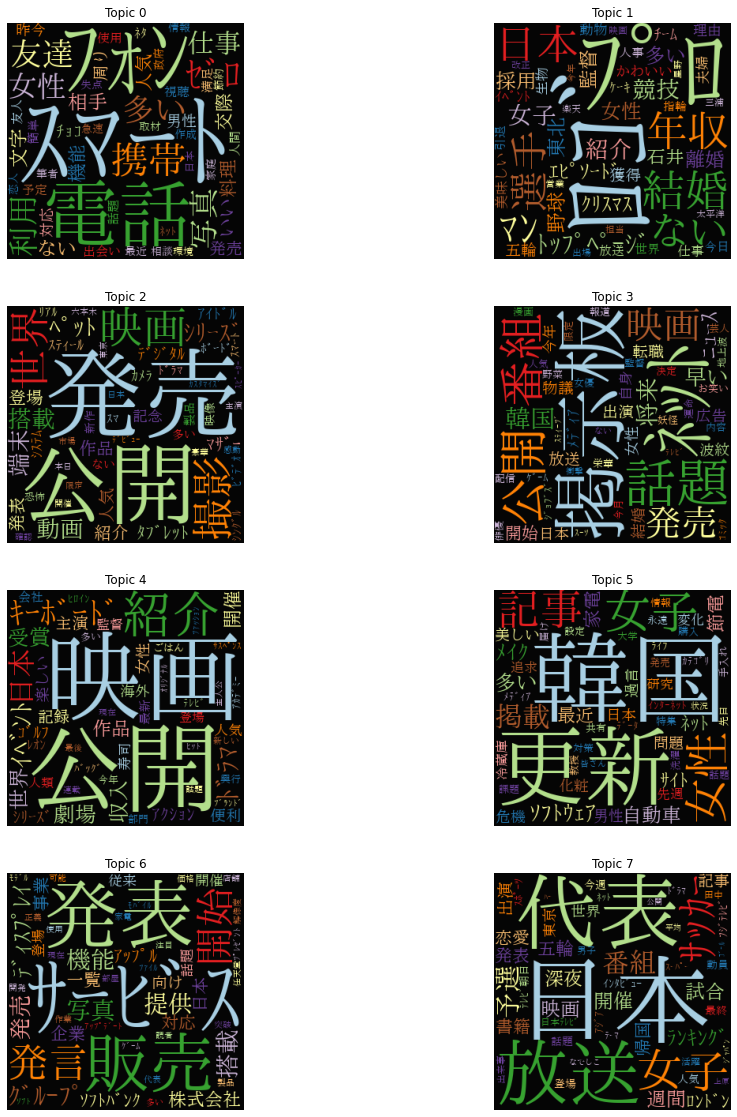

In [ ]:
NUM_WORDS_FOR_WORD_CLOUD = 50

fig, axs = plt.subplots(ncols=2, nrows=math.ceil(lda.num_topics/2), figsize=(16,20))
axs      = axs.flatten()

for i, t in enumerate(range(lda.num_topics)):

    x = dict(lda.show_topic(t, NUM_WORDS_FOR_WORD_CLOUD))
    
    im = WordCloud(
        background_color = 'black',
        max_words        = 4000,
        width            = 300, 
        height           = 300,
        random_state     = 0,
        font_path        = FONT_PATH
    ).generate_from_frequencies(x)
    
    axs[i].imshow(im.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)
    axs[i].axis('off')
    axs[i].set_title('Topic '+str(t))

In [ ]:
N = sum(count for doc in corpus for id, count in doc)

p = perplexity_vals[NUM_TOPICS - START]

print(str(N) + " 個の単語を " + str(int(p)) + " 個程度の情報まで圧縮できた")
print("圧縮率は(注：そんな指標は実際にはないですが、直感的理解のために　) " + str(round(p/N*100, 2)) + " %")

90046 個の単語を 2005 個程度の情報まで圧縮できた
圧縮率は(注：そんな指標は実際にはないですが、直感的理解のために　) 2.23 %


理想を言えば、Perplexityは低ければ低いほど、Coherenceは高ければ高いほど良いとされていますが、これを見る限り、適切なトピック数の設定が難しい結果となりました。

そもそも、Perplexityはトピック数を増やすたびに下降しているようで、これをもって解釈性の良し悪しを決めるのは、何か無理があるような気がします。

Coherenceにしても、一番高いところの値、もしくはCoherenceが上がり続けるような曲線を描いた場合には、対数関数っぽく平坦化してくる部分の手前で最も高いCoherenceの値が算出されたパラメータ値を利用するらしいですが、たいていの実データで実行した場合は、今回のように減少関数っぽくなってしまいます。

これだとあまり決められないので、ひとまず今回は、結果の解釈性なども見て、トピック数8にしました。

Perplexityにしてみれば、およそ2,005ぐらいですので、単語をランダムに選択した場合の語彙数90,046通りに対して、2,005通りぐらいにまで絞れていると考えていると、それはそれで結構良い性能のようにも聞こえます。

トピックモデリングの評価指標に関してはずっと課題のようで、Perplexity、Coherenceだけでなく、他にも様々考えられているようです

## 新しいテキスト（記事）のトピックを識別してみる


識別したテキストは以下とします
Yahooニュースでテキトーに記事をピックアップし、[こちらのサイト](https://tool-taro.com/wget/)でテキスト情報を抽出します。
方式は「タグごとに改行」という設定で抽出します。
抽出したテキストの中から、手動で本文っぽいところをコピペします。

In [ ]:
#https://news.yahoo.co.jp/articles/1fa5ef35a4cbd4432a79d694c5ca61eb540ff7c3
TEXT1 = "サッカーのカタール・ワールドカップ（W杯）はアルゼンチンの36年ぶり3回目の優勝で幕を閉じた。大会公式日本語版ツイッターは日本代表の厳選写真4枚を公開。ファンからは「めちゃくちゃ良い写真ばかり」「既にロスです」と反響が届いている。 　興奮が蘇ってくる。ドイツ、スペインと優勝経験国を破り、決勝トーナメントに進出した日本。決勝T1回戦でクロアチア相手にPK戦の末に惜しくも敗れたが、日本国民に大きな感動を与えた。同公式ツイッターは20日、「#FIFAワールドカップ の思い出としてほしい写真を募集！中の人が夕方までに集まったリクエストにできるだけ応えます」と投稿し、ファンに意見を募っていた。 　その投稿の7時間後、同公式ツイッターは4枚の写真を公開。ソロ写真などではなく、どれも選手が集まっているものだ。歓喜に沸くイレブンや、円陣を組んだ写真が投稿されていた。 　ファンは“珠玉の4枚”に感動。反響が続々と寄せられている。 「3枚目やばい」 「めちゃくちゃ良い写真ばかり」 「何回見てもいいなぁぁ」 「勝ったときは高校の部活のノリ　親しみやすいです」 「3枚目のブラボー兄貴がちょっとコラっぽくて好き」 「本当に今回のSAMURAIBLUEが大好き過ぎて、既にロスです」"

#https://news.yahoo.co.jp/articles/8c8d39dd8b2abfffaf7db02067ae3f7d38de1732
TEXT2 = "大阪府とKDDIは21日、8つの分野において連携と協働する包括連携協定を締結した。同日午後、大阪府庁では吉村洋文知事と髙橋誠KDDI社長が出席し、締結式が開催された。 　包括連携協定では、地域活性化やスマートシティ、環境対策、産業振興、教育、健康、安心安全、府政PRといた8分野が対象となる。 ■ 目玉は「バーチャル大阪」「おおさかecoでんき」 　2者ではかねてより協力を進めてきたが、今回の協定を踏まえ、新たな取り組みとして「バーチャル大阪を活用した大阪の都市魅力の国内外への発信」「おもいでケータイ再起動による地域イベントへの協力」「おおさかecoでんき」などが進められることになった。 　このうち、「バーチャル大阪での展開」と「おおさかecoでんき」は他社にはないユニークな連携例となる。なお、「おおさかecoでんき」については、大阪向け電力サービスとされているが、料金などの詳細は、決まり次第、案内される。 ■ 吉村知事とKDDI髙橋社長が揃って登壇 　吉村知事は、「2025年の万博まで、あと2年ちょっと。万博のリアル（展示）を充実させるのは当然だが、KDDIと協力して進めているのがバーチャル大阪。一歩一歩着実に進めているが、本協定の締結を期に加速させたい。万博期間中はもとより、新たな社会、新たな未来があるということをバーチャルを通じて実現したい」と意気込みを示す。 　大阪府の担当者によれば、万博を開催することは関西圏において一定の認知を得ているものの、全国的にはまだ道半ばと大阪府側では見ているという。KDDIとのバーチャル大阪は、そうした認知拡大の一助と位置づけられる。 　KDDIの髙橋社長は、地域活性化～府政のPRと8分野で連携するなかで、柱として「バーチャル大阪」「おおさかecoでんき」があると位置づける。ユーザーが作り上げるコンテンツ（UCG）や、在阪企業によるコンテンツ、そしてデジタルツインによる現地とバーチャルでの接客など、万博をふくめて大阪を盛り上げたい」と応じる。 　2022年度内に提供される電力サービス「おおさかecoでんき」の料金などはまだ発表されていないが、ユーザーは再生可能比率、実質100％の電力を利用でき、料金の2％を環境保全の基金に寄付できるというもの。大阪府民が大阪府の環境保全に貢献できる内容になるという。"

#https://news.yahoo.co.jp/articles/48a3d12ab5c12b31ba751546cec4f41329cc1724
TEXT3 = "現在公開中の『劇場版 転生したらスライムだった件 紅蓮の絆編』に出演している、声優の内田雄馬さん（30）にインタビュー。本作に初参戦することになった心境やキャラクターの魅力をはじめ、“声の仕事を始めて約10年”という内田さんに10年を振り返っていただきました。 シリーズ累計発行部数3000万部突破の異世界ファンタジー『転生したらスライムだった件』（通称「転スラ」）。初の劇場版作品となった本作は、原作者である伏瀬さん自らが原案を手がけた完全オリジナルストーリーとなっていて、人間からスライムに転生した主人公・リムルたちが、仲間のために陰謀に立ち向かう“絆”の物語となっています。 内田さんは本作のオリジナルキャラクターとなる大鬼族（オーガ）の生き残り、ヒイロを演じます。【画像】声優・内田雄馬「言葉が出てくるというか引き出してもらえる」　共演の古川慎を絶賛■内田雄馬　“兄貴”は「その人の背中を自然と追いたくなるような存在」内田さんが演じたヒイロ　『劇場版 転生したらスライムだった件 紅蓮の絆編』　上映中 　©川上泰樹・伏瀬・講談社／転スラ製作委員会 　配給：バンダイナムコフィルムワークス――本作への参加が決まったときの心境はいかがでしたか？ “転スラ”のシリーズが非常に盛り上がっているというのは存じ上げておりまして、そのシリーズに参加できるということは非常に光栄だなということで、すごく楽しみだなって思ったことを覚えております。 ――ヒイロを演じられた感想や、キャラクターの魅力を教えてください。 今回オリジナルキャラクターというところでシリーズものに参戦するとなると、そこまでの流れであったり、いろいろなことがあっての物語だと思うんですけども、1から描いていただいたというところで、非常に新鮮な気持ちで参戦できたかなというふうに思っております。ヒイロ自体も非常に真っすぐな方（キャラクター）だったので、演じている中で自分としても細かく裏で小細工をするような人じゃないっていうところで、まっすぐ言葉を届けようっていう気持ちで演じられたというのがすごくよかったなというふうに思っております。 ――ヒイロは、古川慎さん演じるベニマルが“兄者”と慕うキャラクターですが、内田さんにとって“兄貴”とはどういう存在だと思われますか？ その人の背中を自然と追いたくなるような、そういう存在なのかなっていうふうに思います。自然とあるっていうか、その自然とある中で自分のこだわりもあるけど、相手の気持ちとかこだわりも感じて受け止めてくださる人。そういう人がカッコいいし、背中を追いたくなるなっていうことだと思うので、そういう人が自分にとっては“兄貴”だなと思えるのかなというふうに感じます。 ――内田さんご自身もそうした存在になっていきたいですか？ そうですね。本当にそういうふうに思ってもらえるように頑張りたいなというのはあります。僕も30歳になったので、年齢が上の方になってきたりもしているので、なるべく本当に僕の背中を見てもらえるように、見てほしいと思っているわけじゃないんですけど（笑）たまたま見た時になんか見て良かったかなって思ってもらえたらいいよねっていうくらいなんですけど。僕は僕らしくやり続けていくのが大事かなと思います。"

In [ ]:
new_data_ss = pd.Series([TEXT1, 
                         TEXT2,
                         TEXT3])

processed_new_data_ss = preprocess_jp(new_data_ss)

# gensim用に成形
new_documents = processed_new_data_ss.values
new_texts     = list(map(lambda x:x.split(), new_documents))

score_by_topic = defaultdict(int)

# Bag-of-Wrodsのコーパスを作成して
# TFIDFコーパスを適用する
new_corpus       = [dictionary.doc2bow(text) for text in new_texts]
new_tfidf_corpus = tfidf_model[new_corpus]

list_score_by_topic = []

# 結果を出力
for unseen_doc in new_tfidf_corpus:
  list_temp = []
  
  for topic, score in lda[unseen_doc]:
    score_by_topic[int(topic)] = float(score)
  
  for i in range(NUM_TOPICS):
    list_temp.append(score_by_topic[i])

  list_score_by_topic.append(list_temp)

# リストをnumpy配列に変換しておく
np_score_by_topic = np.array(list_score_by_topic)
processed_new_data_ss

File already exists.


0    ｻｯｶｰ ｶﾀｰﾙ ﾜｰﾙﾄﾞｶｯﾌﾟ ｱﾙｾﾞﾝﾁﾝ 優勝 大会 公式 日本語 日本 代表...
1    大阪 分野 連携 包括 連携 協定 締結 同日 午後 大阪 府庁 吉村 洋文 知事 社長 出...
2    現在 公開 劇場 転生 紅蓮 出演 声優 内田 ｲﾝﾀﾋﾞｭｰ 参戦 心境 ｷｬﾗｸﾀｰ 魅...
dtype: object

In [ ]:
df_new = pd.DataFrame(new_data_ss)
df_new["topic"] = "topic_"
df_new["prob"]  = .0

for i in range(df_new.shape[0]):
  score_i = np_score_by_topic[i]
  max_id  = score_i.argmax()
  prob_id = score_i[max_id]
  
  df_new.iloc[i,1] = 'topic_{}'.format(max_id)
  df_new.iloc[i,2] = prob_id

df_new

,0,topic,prob
0,サッカーのカタール・ワールドカップ（W杯）はアルゼンチンの36年ぶり3回目の優勝で幕を閉じた...,topic_7,0.491945
1,大阪府とKDDIは21日、8つの分野において連携と協働する包括連携協定を締結した。同日午後、...,topic_3,0.286348
2,現在公開中の『劇場版 転生したらスライムだった件 紅蓮の絆編』に出演している、声優の内田雄馬...,topic_4,0.429012


1番目の記事はサッカーワールドカップのニュース記事なので、トピック7というのは合ってると思います。

2番目の記事は"IT"ニュースの欄の記事なので、期待はトピック0だったのですが、トピック3と判定されました。「話題」「公開」といった単語に反応してしまったのでしょうか？

3番目の記事はエンタメの欄の記事です。期待通りトピック4と判定してくれました。「劇場版」みたいにわかりやすく映画系の文字情報が入っていたからでしょうか？

## ニュース記事のレコメンド

指定した記事と類似性の高い記事を10個おすすめとして提示することを考える。
かみ砕いて言えば、ある記事のidを入力して、それに近いニュース記事を類似度の近い順に出すことを考える（まさしくレコメンド）。

gensimでは、similaritiesというメソッドがあるので、これを使って簡単に実装できる。


---

厳密にいえば、ここで言っている類似性とは、コサイン類似度のこと。


In [ ]:
from gensim import similarities

doc_index = similarities.docsim.MatrixSimilarity(lda[tfidf_corpus])

In [ ]:
target_article = 1

In [ ]:
vec_lda = lda[tfidf_corpus[target_article]]

In [ ]:
NUM_SIMILAR_ARTICLES = 10

s = doc_index.__getitem__(vec_lda)
s = sorted(enumerate(s), key=lambda t: t[1], reverse=True) 


print(s[:NUM_SIMILAR_ARTICLES])

list_similar_articlle = s[1:NUM_SIMILAR_ARTICLES + 1]

[(1, 1.0), (1049, 0.9999955), (6559, 0.9999918), (1040, 0.99987197), (1023, 0.99939394), (2452, 0.9991696), (1179, 0.9988897), (5526, 0.9984339), (902, 0.9982753), (3334, 0.9980832)]


In [ ]:
list_similar_ind = [target_article]
for doc_id, sim in list_similar_articlle:
  list_similar_ind.append(doc_id)

list_similar_ind

[1, 1049, 6559, 1040, 1023, 2452, 1179, 5526, 902, 3334, 6288]

In [ ]:
df_train.iloc[list_similar_ind]

,category,title,content,wakatigaki
1,sports-watch,原監督の采配皮肉る落合氏にファンも同調\n,先週15日、DeNA・中村紀洋のサヨナラ2ランホームランで逆転負けした巨人は、今週からナゴヤ...,先週 中村 紀洋 ｻﾖﾅﾗ ﾗﾝ ﾎｰﾑﾗﾝ 逆転 負け 巨人 今週 ﾅｺﾞﾔ ﾄﾞｰﾑ 場...
1049,sports-watch,【Sports Watch】″すぽると！″番組中、平井アナに大きな違和感\n,15日深夜放送のフジテレビ「すぽると！」では、静岡県富士宮市で発生した震度6の地震により、予...,深夜 放送 ﾌｼﾞﾃﾚﾋﾞ 静岡 富士宮 発生 震度 地震 予定 変更 程度 放送
6559,sports-watch,陸上界のニューヒロイン＝22歳・西原加純。千葉駅伝では3人抜きの快走\n,23日、千葉県総合スポーツセンター陸上競技場では、国際千葉駅伝が行われた。\n,千葉 総合 ｽﾎﾟｰﾂ ｾﾝﾀｰ 陸上 競技 国際 千葉 駅伝
1040,movie-enter,【元気東北・宮城編】仙台から東北そして日本全国へ、ヒーローと凡人との強い絆\n,『アヒルと鴨のコインロッカー』（2007年）や『ゴールデンスランバー』（2010年）など、...,ｱﾋﾙ ｺｲﾝﾛｯｶｰ 宮城 仙台 舞台 作品 発表 伊坂 幸太郎 原作 中村 義洋 監督 ...
1023,sports-watch,岩隈、マリナーズ入団に「“一番に必要としてくれた”というのを感じれた」\n,25日放送、テレビ朝日「報道ステーション」では、同局・宇賀なつみアナウンサーが、シアトル・マ...,放送 ﾃﾚﾋﾞ朝日 報道 ｽﾃｰｼｮﾝ 同局 宇賀 なつみ ｱﾅｳﾝｻｰ ｼｱﾄﾙ ﾏﾘﾅｰ...
2452,topic-news,AKB48出演の「ぷっちょ」CMに「悪寒」「気まずい」とツイッターユーザーが困惑\n,15日からAKB48が出演する「ぷっちょ」のCMが放送され、ツイッターには様々な反応が寄せら...,出演 放送 反応
1179,dokujo-tsushin,もうおばさんのサイン\n,NTTアドの「第2回『見た目年齢』に関する調査」によると、30代女性の42％が「1〜5才若く...,ｱﾄﾞ 見た目 年齢 調査 女性 若い 若い 回答 世代 回答 平均 女性 若い 認識 近頃 女性
5526,sports-watch,なでしこリーグ王者に入団する「かわいすぎるトリオ」\n,12日になでしこリーグ第17節が行われ、INAC神戸がAS狭山を4−0で下し、創部10年目に...,なでしこ ﾘｰｸﾞ 神戸 狭山 創部 悲願 優勝 達成
902,sports-watch,【Sports Watch】阪神選手「“何週間後にナゴヤドームがある”って皆思ってます」\n,31日、プロ野球・日本シリーズ第2戦がナゴヤドームで行われ、中日が千葉ロッテを相手に12-1...,ﾌﾟﾛ 野球 日本 ｼﾘｰｽﾞ ﾅｺﾞﾔ ﾄﾞｰﾑ 中日 千葉ﾛｯﾃ 相手 快勝 対戦 成績
3334,dokujo-tsushin,ロンドン五輪、独女が注目している選手は？\n,7月27日から8月12日までイギリスのロンドンにて開催予定の第30回夏期オリンピック。およそ...,ｲｷﾞﾘｽ ﾛﾝﾄﾞﾝ 開催 予定 夏期 ｵﾘﾝﾋﾟｯｸ 地域 選手 出場 競技 種目 開催...


## scikit learnでSVD

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

count_vectorizer = CountVectorizer()
count_data       = count_vectorizer.fit_transform(processed_news_ss)
tfidf_vectorizer = TfidfTransformer()
tfidf_data       = tfidf_vectorizer.fit_transform(count_data)

print(tfidf_data.toarray()) 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(1000)
svd.fit_transform(tfidf_data)

array([[ 0.0049347 ,  0.00084001,  0.02037702, ..., -0.00021285,
         0.02582419,  0.02954542],
       [ 0.0308084 ,  0.00086177,  0.04207696, ...,  0.01659001,
         0.00022231,  0.00140141],
       [ 0.01328206,  0.00350553,  0.09975599, ...,  0.02570386,
        -0.00646052,  0.01668699],
       ...,
       [ 0.01894376,  0.00652974,  0.13943236, ..., -0.00176077,
        -0.0059487 ,  0.01846034],
       [ 0.00403904,  0.00142655,  0.03411927, ..., -0.02810621,
        -0.00756976, -0.01291526],
       [ 0.01352098,  0.00307764,  0.09108076, ...,  0.00512547,
        -0.00934044,  0.01049746]])

Explained Variance Ratio Sum: 0.6148176764490809


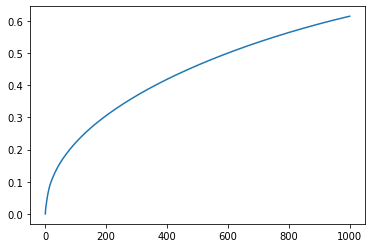

In [ ]:
print('Explained Variance Ratio Sum:', svd.explained_variance_ratio_.sum())
ev_ratio = svd.explained_variance_ratio_
ev_ratio = np.hstack([0,ev_ratio.cumsum()])
plt.plot(ev_ratio)
plt.show()

## テストデータの処理

In [ ]:
# gensim用に成形
test_documents = df_test.wakatigaki.values
test_texts     = list(map(lambda x:x.split(), test_documents))

score_by_topic = defaultdict(int)
test_corpus    = [dictionary.doc2bow(text) for text in test_texts]

# 作成したモデルにTFIDFコーパスを適用する
test_tfidf_corpus = tfidf_model[test_corpus]

In [ ]:
list_score_by_topic = []

# 結果を出力
for unseen_doc in test_tfidf_corpus:
  list_temp = []
  
  for topic, score in lda[unseen_doc]:
    score_by_topic[int(topic)] = float(score)
  
  for i in range(NUM_TOPICS):
    list_temp.append(score_by_topic[i])

  list_score_by_topic.append(list_temp)

In [ ]:
list_column_name = ['topic_{}'.format(i) for i in range(NUM_TOPICS)]

df_score_by_topic = pd.DataFrame(list_score_by_topic, columns = list_column_name)

df_score_by_topic

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7
0,0.000000,0.000000,0.592341,0.000000,0.000000,0.000000,0.392029,0.000000
1,0.558861,0.000000,0.592341,0.000000,0.000000,0.000000,0.419666,0.000000
2,0.398815,0.000000,0.592341,0.000000,0.000000,0.574014,0.419666,0.000000
3,0.398815,0.000000,0.592341,0.177351,0.221937,0.574014,0.419666,0.596226
4,0.398815,0.195199,0.592341,0.598778,0.221937,0.574014,0.419666,0.197839
...,...,...,...,...,...,...,...,...
732,0.021640,0.021637,0.021652,0.021642,0.021639,0.021640,0.848496,0.021655
733,0.021640,0.021637,0.021652,0.021642,0.996028,0.021640,0.848496,0.021655
734,0.021640,0.021637,0.562438,0.256544,0.172583,0.021640,0.848496,0.021655
735,0.963024,0.021637,0.562438,0.256544,0.172583,0.021640,0.848496,0.021655


In [ ]:
# もともとのテストDataFrameと結合

df_test = pd.concat([df_test, df_score_by_topic], axis = 1)
df_test

,category,title,content,wakatigaki,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7
0,it-life-hack,Windows 8 Proが1200円！ 「Windows 8 優待購入プログラム」【デジ通】\n,Windows 8の発売が、あと2カ月弱に近づいてきた。新Windowsの登場が近くなると、...,発売 登場 ｷｬﾝﾊﾟｰ 優待 販売 優待 購入 ﾌﾟﾛｸﾞﾗﾑ 提供 発表,0.000000,0.000000,0.592341,0.000000,0.000000,0.000000,0.392029,0.000000
1,smax,テレコムスクエア、海外で利用できる「世界のSIMカード」を800円／月に値下げ！事務手数料無...,値下げや利用可能国が拡大！ \n,値下げ 利用 可能 拡大,0.558861,0.000000,0.592341,0.000000,0.000000,0.000000,0.419666,0.000000
2,smax,NTTドコモ、関東甲信越・東海・関西地域の契約者の一部ユーザーで通信障害によってFOMAおよ...,NTTドコモに通信障害！ \n,ﾄﾞｺﾓ 通信 障害,0.398815,0.000000,0.592341,0.000000,0.000000,0.574014,0.419666,0.000000
3,topic-news,五輪メダリストに無茶な要求をする番組に、ユーザは「中継が見苦しい」\n,20日、「情報ライブ ミヤネ屋」（日本テレビ系）では、都内で行われたロンドン五輪・メダリスト...,情報 ﾗｲﾌﾞ 日本ﾃﾚﾋﾞ 都内 ﾛﾝﾄﾞﾝ 五輪 ﾒﾀﾞﾘｽﾄ 凱旋 ﾊﾟﾚｰﾄﾞ 中継...,0.398815,0.000000,0.592341,0.177351,0.221937,0.574014,0.419666,0.596226
4,topic-news,大御所ビートたけしに対しても空気を読まないオードリー・春日の発言に、伊集院光「衝撃受けた」\n,16日に放送された「伊集院光 深夜の馬鹿力」（TBSラジオ）で、大御所ビートたけしを相手に空...,放送 伊集院 深夜 馬鹿力 ﾗｼﾞｵ 大御所 ﾋﾞｰﾄたけし 相手 空気 ｵｰﾄﾞﾘｰ 春日...,0.398815,0.195199,0.592341,0.598778,0.221937,0.574014,0.419666,0.197839
...,...,...,...,...,...,...,...,...,...,...,...,...
732,smax,NTTドコモ、Android 4.0 ICS搭載3.7インチスマホ「ARROWS Me F-...,ARROWS Me F-11Dが発表！ \n,発表,0.021640,0.021637,0.021652,0.021642,0.021639,0.021640,0.848496,0.021655
733,movie-enter,監督が予想しなかったラブストーリーと“映画通ほどダマされる”結末\n,全米でこの春公開され、観る者の想像を完璧なまでに裏切る鮮やかなプロットで映画ファンを騒然と...,全米 公開 想像 完璧 鮮やか ﾌﾟﾛｯﾄ 映画 ﾌｧﾝ 騒然 衝撃 ｻｽﾍﾟﾝｽ ｱｸｼｮ...,0.021640,0.021637,0.021652,0.021642,0.996028,0.021640,0.848496,0.021655
734,it-life-hack,日本最大級のショッピングポータルがオープン！「イオンスクエア」が凄い理由\n,武井 咲さんのテレビCMでお馴染みのイオンは、豊富な品揃えとユニークなキャンペーンが大きな魅...,武井 ﾃﾚﾋﾞ 馴染み ｲｵﾝ 豊富 ﾕﾆｰｸ ｷｬﾝﾍﾟｰﾝ 魅力,0.021640,0.021637,0.562438,0.256544,0.172583,0.021640,0.848496,0.021655
735,livedoor-homme,35歳からの肉体改造、“オヤジクラス”で充実したライフスタイルを——【新生活特集】\n,新生活とは、何も学生やフレッシュマンだけにある言葉ではありませんよね。\n,生活 学生 ﾌﾚｯｼｭﾏﾝ 言葉,0.963024,0.021637,0.562438,0.256544,0.172583,0.021640,0.848496,0.021655
